# Joint Intent Classification and Slot Filling with Transformers

The goal of this notebook is to fine-tune a pretrained transformer-based neural network model to convert a user query expressed in English into
a representation that is structured enough to be processed by an automated service.

Here is an example of interpretation computed by such a Natural Language Understanding system:

```python
>>> simple_nlu(
...     "Book a table for two at Le Ritz for Friday night",
        tokenizer, joint_model, intent_names, slot_names,
... )
```
```
{
    'intent': 'BookRestaurant',
    'slots': {
        'party_size_number': 'two',
        'restaurant_name': 'Le Ritz',
        'timeRange': 'Friday night'
    }
}
```

Intent classification is a simple sequence classification problem. The trick is to treat the structured knowledge extraction part ("Slot Filling") as token-level classification problem using BIO-annotations:

```python
>>> show_predictions("Book a table for two at Le Ritz for Friday night!",
...                  tokenizer, joint_model, intent_names, slot_names)
```
```
## Intent: BookRestaurant
## Slots:
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O
```

We will show how to train a such as join "sequence classification" and "token classification" joint model on a [voice command dataset]() published by snips.ai.


This notebook is a partial reproduction of some of the results presented in this paper:

BERT for Joint Intent Classification and Slot Filling
Qian Chen, Zhu Zhuo, Wen Wang

https://arxiv.org/abs/1902.10909

In [1]:
import torch
torch.__version__

'2.0.0'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
%pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


## The Data

We will use a speech command dataset collected, annotated and published by French startup SNIPS.ai (bought in 2019 by Audio device manufacturer Sonos).

The original dataset comes in [YAML format with inline markdown annotations](https://snips-nlu.readthedocs.io/en/latest/dataset.html).

Instead we will use a preprocessed variant with token level B-I-O annotations closer the representation our model will predict. This variant of the SNIPS
dataset was prepared by [Su Zhu](https://github.com/sz128).



In [4]:
from urllib.request import urlretrieve
from pathlib import Path


SNIPS_DATA_BASE_URL = (
    "https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/blob/"
    "master/data/snips/"
)
for filename in ["train", "valid", "test", "vocab.intent", "vocab.slot"]:
    path = Path(filename)
    if not path.exists():
        print(f"Downloading {filename}...")
        urlretrieve(SNIPS_DATA_BASE_URL + filename + "?raw=true", path)

Let's have a look at the first lines from the training set:

In [5]:
lines_train = Path("train").read_text("utf-8").strip().splitlines()
lines_train[:5]

['Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist',
 'put:O United:B-entity_name Abominations:I-entity_name onto:O my:B-playlist_owner rare:B-playlist groove:I-playlist playlist:O <=> AddToPlaylist',
 'add:O the:O tune:B-music_item by:O misato:B-artist watanabe:I-artist to:O the:O Trapeo:B-playlist playlist:O <=> AddToPlaylist',
 'add:O this:O artist:B-music_item to:O my:B-playlist_owner this:B-playlist is:I-playlist miguel:I-playlist bosé:I-playlist playlist:O <=> AddToPlaylist',
 'add:O heresy:B-entity_name and:I-entity_name the:I-entity_name hotel:I-entity_name choir:I-entity_name to:O the:O evening:B-playlist acoustic:I-playlist playlist:O <=> AddToPlaylist']

Some remarks:

- The class label for the voice command appears at the end of each line (after the "<=>" marker).
- Each word-level token is annotated with B-I-O labels using the ":" separator.
- B/I/O stand for "Beginning" / "Inside" / "Outside"
- "Add:O" means that the token "Add" is "Outside" of any annotation span
- "Don:B-entity_name" means that "Don" is the "Beginning" of an annotation of type "entity-name".
- "and:I-entity_name" means that "and" is "Inside" the previously started annotation of type "entity-name".


Let's write a parsing function and test it on the first line:

In [6]:
def parse_line(line):
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label,
        "words": " ".join(words),
        "word_labels": " ".join(word_labels),
        "length": len(words),
    }

In [7]:
parse_line(lines_train[0])

{'intent_label': 'AddToPlaylist',
 'words': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'word_labels': 'O B-entity_name I-entity_name I-entity_name O B-playlist_owner B-playlist I-playlist I-playlist I-playlist I-playlist O',
 'length': 12}

This utterance is a voice command of type "AddToPlaylist" with to annotations:

- an entity-name: "Don and Sherri",
- a playlist: "Medidate to Sounds of Nature".


The goal of this project is to build a baseline Natural Understanding model to analyse such voice commands and predict:

- the intent of the speaker: the sentence level class label ("AddToPlaylist");
- extract the interesting "slots" (typed named entities) from the sentence by performing word level classification using the B-I-O tags as target classes. This second task is often referred to as "NER" (Named Entity Recognition) in the Natural Language Processing literature. Alternatively this is also known as "slot filling" when we expect a fixed set of named entity per sentence of a given class.

The list of possible classes for the sentence level and the word level classification problems are given as:




In [8]:
print(Path("vocab.intent").read_text("utf-8"))

AddToPlaylist
BookRestaurant
GetWeather
PlayMusic
RateBook
SearchCreativeWork
SearchScreeningEvent



In [9]:
print(Path("vocab.slot").read_text("utf-8"))

B-album
B-artist
B-best_rating
B-city
B-condition_description
B-condition_temperature
B-country
B-cuisine
B-current_location
B-entity_name
B-facility
B-genre
B-geographic_poi
B-location_name
B-movie_name
B-movie_type
B-music_item
B-object_location_type
B-object_name
B-object_part_of_series_type
B-object_select
B-object_type
B-party_size_description
B-party_size_number
B-playlist
B-playlist_owner
B-poi
B-rating_unit
B-rating_value
B-restaurant_name
B-restaurant_type
B-served_dish
B-service
B-sort
B-spatial_relation
B-state
B-timeRange
B-track
B-year
I-album
I-artist
I-city
I-country
I-cuisine
I-current_location
I-entity_name
I-facility
I-genre
I-geographic_poi
I-location_name
I-movie_name
I-movie_type
I-music_item
I-object_location_type
I-object_name
I-object_part_of_series_type
I-object_select
I-object_type
I-party_size_description
I-playlist
I-playlist_owner
I-poi
I-restaurant_name
I-restaurant_type
I-served_dish
I-service
I-sort
I-spatial_relation
I-state
I-timeRange
I-track
O



"POI" stands for "Point of Interest".

Let's parse all the lines and store the results in pandas DataFrames:

In [10]:
import pandas as pd

parsed = [parse_line(line) for line in lines_train]

df_train = pd.DataFrame([p for p in parsed if p is not None])
df_train

,intent_label,words,word_labels,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11
...,...,...,...,...
13079,SearchScreeningEvent,find a Consolidated Theatres showing The Good ...,O O B-location_name I-location_name O B-movie_...,10
13080,SearchScreeningEvent,where can i see animated movies in the neighbo...,O O O O B-movie_type I-movie_type B-spatial_re...,9
13081,SearchScreeningEvent,Showtimes for animated movies in the area .,O O B-movie_type I-movie_type B-spatial_relati...,8
13082,SearchScreeningEvent,Which animated movies are playing at Megaplex ...,O B-movie_type I-movie_type O O O B-location_n...,11


In [11]:
df_train

,intent_label,words,word_labels,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11
...,...,...,...,...
13079,SearchScreeningEvent,find a Consolidated Theatres showing The Good ...,O O B-location_name I-location_name O B-movie_...,10
13080,SearchScreeningEvent,where can i see animated movies in the neighbo...,O O O O B-movie_type I-movie_type B-spatial_re...,9
13081,SearchScreeningEvent,Showtimes for animated movies in the area .,O O B-movie_type I-movie_type B-spatial_relati...,8
13082,SearchScreeningEvent,Which animated movies are playing at Megaplex ...,O B-movie_type I-movie_type O O O B-location_n...,11


In [12]:
df_train.groupby("intent_label").count()

,words,word_labels,length
intent_label,,,
AddToPlaylist,1842,1842,1842
BookRestaurant,1873,1873,1873
GetWeather,1900,1900,1900
PlayMusic,1900,1900,1900
RateBook,1856,1856,1856
SearchCreativeWork,1854,1854,1854
SearchScreeningEvent,1859,1859,1859


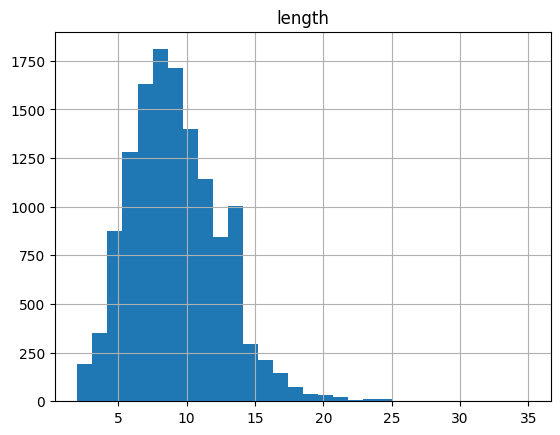

In [13]:
df_train.hist("length", bins=30);

In [14]:
lines_valid = Path("valid").read_text("utf-8").strip().splitlines()
lines_test = Path("test").read_text("utf-8").strip().splitlines()

df_valid = pd.DataFrame([parse_line(line) for line in lines_valid])
df_test = pd.DataFrame([parse_line(line) for line in lines_test])


## A First Model: Intent Classification (Sentence Level)

Let's ignore the slot filling task for now and let's try to build a sentence level classifier by fine-tuning a pre-trained Transformer-based model using the `huggingface/transformers` package that provides both TF2/Keras and Pytorch APIs.

### The BERT Tokenizer

First let's load a pre-trained tokenizer and test it on a test sentence from the training set:

In [15]:
from transformers import BertTokenizer

model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [16]:
first_sentence = df_train.iloc[0]["words"]
first_sentence

'Add Don and Sherri to my Meditate to Sounds of Nature playlist'

In [17]:
tokenizer.tokenize(first_sentence)

['Ad',
 '##d',
 'Don',
 'and',
 'She',
 '##rri',
 'to',
 'my',
 'Me',
 '##dit',
 '##ate',
 'to',
 'Sounds',
 'of',
 'Nature',
 'play',
 '##list']

Notice that BERT uses subword tokens so the length of the tokenized sentence is likely to be larger than the number of words in the sentence.

**Question**:

- why is it particulary interesting to use subword tokenization for general purpose language models such as BERT?


Each token string is mapped to a unique integer id that makes it fast to lookup the right column in the input layer token embedding:

In [18]:
tokenizer.encode(first_sentence)

[101,
 24930,
 1181,
 1790,
 1105,
 1153,
 14791,
 1106,
 1139,
 2508,
 17903,
 2193,
 1106,
 10560,
 1104,
 7009,
 1505,
 7276,
 102]

In [19]:
tokenizer.decode(tokenizer.encode(first_sentence))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'[CLS] Add Don and Sherri to my Meditate to Sounds of Nature playlist [SEP]'

Remarks:

- The first token `[CLS]` is used by the pre-training task for sequence classification.
- The last token `[SEP]` is a separator for the pre-training task that classifiies if a pair of sentences are consecutive in a corpus or not (next sentence prediction).
- Here we want to use BERT to compute a representation of a single voice command at a time
- We could reuse the representation of the `[CLS]` token for sequence classification.
- Alternatively we can pool the representations of all the tokens of the voice command (e.g. global average) and use that as the input of the final sequence classification layer.

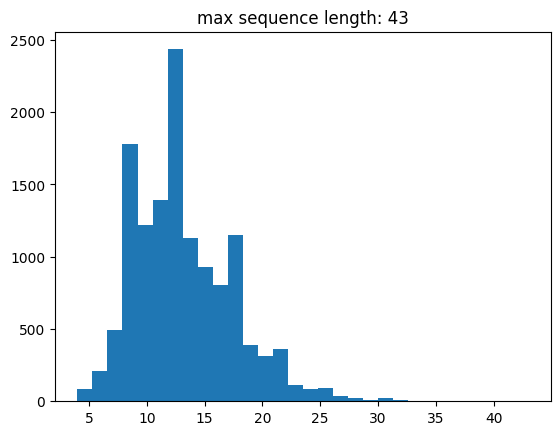

In [20]:
import matplotlib.pyplot as plt

train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");

To perform transfer learning, we will need to work with padded sequences so they all have the same sizes. The above histograms, shows that after tokenization, 43 tokens are enough to represent all the voice commands in the training set.

The mapping can be introspected in the `tokenizer.vocab` attribute:

In [21]:
tokenizer.vocab_size

28996

In [22]:
bert_vocab_items = list(tokenizer.vocab.items())
bert_vocab_items[:10]

[('[PAD]', 0),
 ('[unused1]', 1),
 ('[unused2]', 2),
 ('[unused3]', 3),
 ('[unused4]', 4),
 ('[unused5]', 5),
 ('[unused6]', 6),
 ('[unused7]', 7),
 ('[unused8]', 8),
 ('[unused9]', 9)]

In [23]:
bert_vocab_items[100:110]

[('[UNK]', 100),
 ('[CLS]', 101),
 ('[SEP]', 102),
 ('[MASK]', 103),
 ('[unused100]', 104),
 ('[unused101]', 105),
 ('!', 106),
 ('"', 107),
 ('#', 108),
 ('$', 109)]

In [24]:
bert_vocab_items[900:910]

[('く', 900),
 ('け', 901),
 ('こ', 902),
 ('さ', 903),
 ('し', 904),
 ('す', 905),
 ('せ', 906),
 ('そ', 907),
 ('た', 908),
 ('ち', 909)]

In [25]:
bert_vocab_items[1100:1110]

[('－', 1100),
 ('／', 1101),
 ('：', 1102),
 ('the', 1103),
 ('of', 1104),
 ('and', 1105),
 ('to', 1106),
 ('in', 1107),
 ('was', 1108),
 ('The', 1109)]

In [26]:
bert_vocab_items[20000:20010]

[('attested', 20000),
 ('Hillary', 20001),
 ('##DM', 20002),
 ('gal', 20003),
 ('wander', 20004),
 ('Salle', 20005),
 ('##laming', 20006),
 ('Perez', 20007),
 ('Pit', 20008),
 ('##LP', 20009)]

In [27]:
bert_vocab_items[-10:]

[('##한', 28986),
 ('##ﬁ', 28987),
 ('##ﬂ', 28988),
 ('##！', 28989),
 ('##（', 28990),
 ('##）', 28991),
 ('##，', 28992),
 ('##－', 28993),
 ('##／', 28994),
 ('##：', 28995)]

Couple of remarks:

- 30K is a reasonable vocabulary size and is small enough to be used in a softmax output layer;
- it can represent multi-lingual sentences, including non-Western alphabets;
- subword tokenization makes it possible to deal with typos and morphological variations with a small vocabulary side and without any language-specific preprocessing;
- subword tokenization makes it unlikely to use the `[UNK]` special token as rare words can often be represented as a sequence of frequent enough short subwords in a meaningful way.

### Encoding the Dataset with the Tokenizer

Let's now encode the full train / valid and test sets with our tokenizer to get a padded integer numpy arrays:

In [28]:
import numpy as np


def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(
        shape=(len(text_sequences), max_length),
        dtype=np.int32,
    )
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    return torch.from_numpy(token_ids)


encoded_train = encode_dataset(tokenizer, df_train["words"], max_length=45)
encoded_train

tensor([[  101, 24930,  1181,  ...,     0,     0,     0],
        [  101,  1508,  1244,  ...,     0,     0,     0],
        [  101,  5194,  1103,  ...,     0,     0,     0],
        ...,
        [  101, 27640,  1116,  ...,     0,     0,     0],
        [  101,  5979,  6608,  ...,     0,     0,     0],
        [  101,  1327,  2523,  ...,     0,     0,     0]], dtype=torch.int32)

In [29]:
encoded_valid = encode_dataset(tokenizer, df_valid["words"], max_length=45)
encoded_test = encode_dataset(tokenizer, df_test["words"], max_length=45)

### Questions
    
- How many elements in the training set and validation set tensors (hint introspect the shape of the tensors in a new code cell)?
- What is size of a float32 or int32 element in Byte (1 Byte == 8 bits)?
- How many MB (millions of Bytes) or GB (billions of Bytes) is used in memory by those tensors?
- Do you think those tensors can fit all at once in a single typical GPU device memory?

### Encoding the Sequence Classification Targets

To do so we build a simple mapping from the auxiliary files:

In [30]:
intent_names = Path("vocab.intent").read_text("utf-8").split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [31]:
intent_train = torch.from_numpy(df_train["intent_label"].map(intent_map).values)
intent_train

tensor([0, 0, 0,  ..., 6, 6, 6])

In [32]:
intent_valid = torch.from_numpy(df_valid["intent_label"].map(intent_map).values)
intent_test = torch.from_numpy(df_test["intent_label"].map(intent_map).values)

### Wrapping the Encoded Data into a Classification Dataset

In order to train a model with Stochastic Gradient Descent on shuffled minibatches, it is convenient to wrap the input and target data into a [Dataset object, suitable for consumption via DataLoader objects](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Since this dataset is very small and can easily fit in device memory all at once, we move everything there ahead of time to avoid Host to Device memory transfers during training. 

In [33]:
from torch.utils.data import TensorDataset


intent_dataset_train = TensorDataset(encoded_train.to(device), intent_train.to(device))
intent_dataset_valid = TensorDataset(encoded_valid.to(device), intent_valid.to(device))
intent_dataset_test = TensorDataset(encoded_test.to(device), intent_test.to(device))

We can then use a standard PyTorch `DataLoader` to shuffle and chunk the data into minibatches:

In [34]:
from torch.utils.data import DataLoader

batch_size = 64
intent_dataset_train_dataloader = DataLoader(intent_dataset_train, batch_size=batch_size, shuffle=True)
intent_dataset_valid_dataloader = DataLoader(intent_dataset_valid, batch_size=batch_size, shuffle=True)
intent_dataset_test_dataloader = DataLoader(intent_dataset_test, batch_size=batch_size, shuffle=True)

In [35]:
for input_ids_batch, intent_labels_batch in intent_dataset_train_dataloader:
    print("## batch of input_ids:")
    print(input_ids_batch)
    print()
    print("## batch of intent_labels:")
    print(intent_labels_batch)
    print(intent_labels_batch.shape)
    
    break  # just display the first batch

## batch of input_ids:
tensor([[  101,  1184,  1110,  ...,     0,     0,     0],
        [  101,  5194,  3579,  ...,     0,     0,     0],
        [  101,  5194,   124,  ...,     0,     0,     0],
        ...,
        [  101,  1815, 27549,  ...,     0,     0,     0],
        [  101,   146,  1444,  ...,     0,     0,     0],
        [  101,  1505,  5712,  ...,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)

## batch of intent_labels:
tensor([2, 0, 0, 5, 5, 2, 5, 0, 3, 1, 4, 0, 1, 2, 2, 6, 2, 4, 5, 4, 0, 2, 1, 0,
        3, 3, 1, 3, 5, 2, 6, 2, 6, 4, 2, 1, 6, 0, 1, 6, 5, 3, 4, 4, 6, 3, 1, 6,
        3, 4, 1, 1, 6, 0, 6, 3, 2, 0, 3, 2, 1, 0, 1, 5], device='cuda:0')
torch.Size([64])


## Note on Measuring the Speed of the DataLoader

In [36]:
from time import perf_counter

total_num_samples = 0
total_nbytes = 0
tic = perf_counter()

for _ in range(30):
    for input_ids, target_labels in intent_dataset_train_dataloader:
        total_num_samples += input_ids.shape[0]
        total_nbytes += np.prod(input_ids.shape) * 4  # 32 bits is 4 bytes
        total_nbytes += np.prod(target_labels.shape) * 4  # 32 bits is 4 bytes
    
toc = perf_counter()
duration = toc - tic
print(
    f"DataLoader throughput: {total_nbytes / 1e6 / (duration):.1f} MB/s"
    f" {total_num_samples / (duration):.1f} doc/s"
)

DataLoader throughput: 18.2 MB/s 99181.4 doc/s


### Loading and Feeding a Pretrained BERT model

Let's load a pretrained BERT model using the [huggingface transformers](https://github.com/huggingface/transformers) package:

In [37]:
from transformers import AutoModel

base_bert_model = AutoModel.from_pretrained("bert-base-cased").to(device)

You can ignore the warnings. Here we plan to use the low-level Pytorch objects directly instead of using the Huggingface `transformers` abstractions for educational purpose. Feel free to have a look at the huggingface tutorials to fine tune classification models directly using the Huggingface classes and get rid of those warnings.

In [38]:
# base_bert_model

In [39]:
# base_bert_model.forward?

In [40]:
input_ids_batch

tensor([[  101,  1184,  1110,  ...,     0,     0,     0],
        [  101,  5194,  3579,  ...,     0,     0,     0],
        [  101,  5194,   124,  ...,     0,     0,     0],
        ...,
        [  101,  1815, 27549,  ...,     0,     0,     0],
        [  101,   146,  1444,  ...,     0,     0,     0],
        [  101,  1505,  5712,  ...,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)

In [41]:
with torch.no_grad():
    best_outputs = base_bert_model(input_ids=input_ids_batch)

type(best_outputs)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions

The **first ouput** of the BERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes **features for each token in the input sequence**:

In [42]:
best_outputs.last_hidden_state.shape

torch.Size([64, 45, 768])

The **second output** of the BERT model is a tensor with shape `(batch_size, output_dim)` which is the vector representation of the special token `[CLS]`. This vector is typically used as a **pooled representation for the sequence as a whole**. This is will be used as the features of our Intent classifier:

In [43]:
best_outputs.pooler_output.shape

torch.Size([64, 768])

### Exercise: Fine Tune BERT as an Intent Classifier

Use the following code template to build and train a **sequence classification model** using to predict the **intent class**.

Use the `self.bert` pre-trained model in the `call` method and only consider the pooled features (ignore the token-wise features for now).

Check that your **untrained** model is functional by computing a foward pass on an arbitrary random mini-batch from the training set.

In [44]:
class IntentClassificationModel(torch.nn.Module):

    def __init__(
        self,
        intent_num_labels=None,
        model_name="bert-base-cased",
        dropout_prob=0.1,
    ):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)

        # TODO: write your code here

    def forward(self, input_ids):
        bert_outputs = self.bert(input_ids=input_ids)

        # TODO: write your code here


# Uncomment the following lines to test the forward pass of the model:

# intent_model = IntentClassificationModel(intent_num_labels=len(intent_map)).to(device)
# with torch.no_grad():
#     input_ids, target_labels = next(iter(intent_dataset_train_dataloader))
#     predicted_logits = intent_model(input_ids_batch)
#
# predicted_logits.shape

### Solution

In [45]:
class IntentClassificationModel(torch.nn.Module):

    def __init__(
        self,
        intent_num_labels=None,
        model_name="bert-base-cased",
        dropout_prob=0.1,
    ):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(dropout_prob)

        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function
        # instead of the model itself.
        self.intent_classifier = torch.nn.Linear(768, intent_num_labels)

    def forward(self, input_ids):
        bert_outputs = self.bert(input_ids=input_ids)
        pooled_output = self.dropout(bert_outputs.pooler_output)
        
        intent_logits = self.intent_classifier(pooled_output)
        return intent_logits


intent_model = IntentClassificationModel(intent_num_labels=len(intent_map)).to(device)
intent_model.eval()

with torch.no_grad():
    input_ids, target_labels = next(iter(intent_dataset_train_dataloader))
    predicted_logits = intent_model(input_ids_batch)

predicted_logits.shape

torch.Size([64, 7])

Our classification model outputs logits instead of probabilities. The final softmax normalization layer is implicit, that is included in the loss function instead of the model directly.



### Exercice: Fine Tune the Intent Classification Model

- Write an evaluation loop to measure the accuracy on the validation set
- Write a training loop with Adam (with a small learning rate, e.g. 3e-5) to train the intent classification model end to end.
- Train the model for 2 epochs and report the final validation accuracy.

In [46]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(intent_model.parameters(), lr=3e-5)

In [47]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # enable dropout layer(s)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()  # disable dropout layer(s)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float32).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [48]:
test_loop(intent_dataset_valid_dataloader, intent_model, loss_fn)

Test Error: 
 Accuracy: 16.0%, Avg loss: 1.974123 



In [49]:
len(intent_map)

7

In [50]:
1 / len(intent_map)

0.14285714285714285

In [51]:
epochs = 2

for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loop(intent_dataset_train_dataloader, intent_model, loss_fn, optimizer)
    test_loop(intent_dataset_valid_dataloader, intent_model, loss_fn)

Epoch 1
loss: 1.953417  [    0/13084]
loss: 0.065095  [ 6400/13084]
loss: 0.146368  [12800/13084]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.057722 

Epoch 2
loss: 0.027064  [    0/13084]
loss: 0.026420  [ 6400/13084]
loss: 0.104021  [12800/13084]
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.053264 



In [52]:
def classify(text, tokenizer, model, intent_names):
    input_ids = torch.from_numpy(np.asarray(tokenizer.encode(text)))[None, :]  # batch_size = 1
    class_id = model(input_ids.to(device)).argmax(axis=1)[0].item()
    return intent_names[class_id]


classify(
    "Book a table for two at La Tour d'Argent for Friday night.",
    tokenizer, intent_model, intent_names,
)

'BookRestaurant'

In [53]:
classify(
    "I would like to listen to Anima by Thom Yorke.",
    tokenizer, intent_model, intent_names,
)

'PlayMusic'

In [54]:
classify(
    "Will it snow tomorrow in Vannes?",
    tokenizer, intent_model, intent_names,
)

'GetWeather'

In [55]:
classify(
    "Where can I see to the last Star Wars in Strasbourg tonight?",
    tokenizer, intent_model, intent_names,
)

'SearchScreeningEvent'

Let's free some GPU memory before attempting to build the joint model.

In [56]:
del intent_model
del intent_dataset_train
del intent_dataset_train_dataloader
del intent_dataset_valid
del intent_dataset_valid_dataloader
del intent_dataset_test
del intent_dataset_test_dataloader

## Join Intent Classification and Slot Filling

Let's now refine our Natural Language Understanding system by trying the retrieve the important structured elements of each voici command.

To do so we will perform word level (or token level) classification of the BIO labels.

Since we have word level tags but BERT uses a wordpiece tokenizer, we need to align the BIO labels with the BERT tokens.


Let's load the list of possible word token labels and augment it with an additional padding label to be able to ignore special tokens:

In [57]:
slot_names = ["[PAD]"]
slot_names += Path("vocab.slot").read_text("utf-8").strip().splitlines()
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
slot_map

{'[PAD]': 0,
 'B-album': 1,
 'B-artist': 2,
 'B-best_rating': 3,
 'B-city': 4,
 'B-condition_description': 5,
 'B-condition_temperature': 6,
 'B-country': 7,
 'B-cuisine': 8,
 'B-current_location': 9,
 'B-entity_name': 10,
 'B-facility': 11,
 'B-genre': 12,
 'B-geographic_poi': 13,
 'B-location_name': 14,
 'B-movie_name': 15,
 'B-movie_type': 16,
 'B-music_item': 17,
 'B-object_location_type': 18,
 'B-object_name': 19,
 'B-object_part_of_series_type': 20,
 'B-object_select': 21,
 'B-object_type': 22,
 'B-party_size_description': 23,
 'B-party_size_number': 24,
 'B-playlist': 25,
 'B-playlist_owner': 26,
 'B-poi': 27,
 'B-rating_unit': 28,
 'B-rating_value': 29,
 'B-restaurant_name': 30,
 'B-restaurant_type': 31,
 'B-served_dish': 32,
 'B-service': 33,
 'B-sort': 34,
 'B-spatial_relation': 35,
 'B-state': 36,
 'B-timeRange': 37,
 'B-track': 38,
 'B-year': 39,
 'I-album': 40,
 'I-artist': 41,
 'I-city': 42,
 'I-country': 43,
 'I-cuisine': 44,
 'I-current_location': 45,
 'I-entity_name': 

In [58]:
len(slot_map)

73

The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is too long to be represented as a single token, we expand its label for all the tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word:

In [59]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map,
                        max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int64)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return torch.from_numpy(encoded).to(device)


slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, max_length=45)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, max_length=45)
slot_test = encode_token_labels(
    df_test["words"], df_test["word_labels"], tokenizer, slot_map, max_length=45)

In [60]:
slot_train[0]

tensor([ 0, 72, 72, 10, 46, 46, 46, 72, 26, 25, 60, 60, 60, 60, 60, 60, 72, 72,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')

In [61]:
slot_valid[0]

tensor([ 0,  2, 41, 41, 72, 72, 72, 26, 25, 72, 72,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions recieve a 0 label.

### Exercise

- Write a `JointIntentAndSlotFillingModel` that predicts both the per-token slot classes and sequence level intent class.
- Check that the forward pass runs without crashing with randomly initialized weights on an arbitrary batch of data
- Look at the shapes of the outputs of the model, do they match your expectations?
- Define a new data loader that returns both sequence-level and token-level class labels (optional, feel free to directly run the solution if late)
- Train it on the training set using the sum of a sequence level cross-entropy loss for intent classification and token level cross-entropy loss for slot BIO classification (optional, feel free to directly run the solution if late).
- Monitor the accuracies on the validation set while training  (optional, feel free to directly run the solution if late).


In [62]:
class JointIntentAndSlotFillingModel(torch.nn.Module):
    # TODO: write me!
    pass




















### Solution:


In [63]:
class JointIntentAndSlotFillingModel(torch.nn.Module):

    def __init__(
        self,
        intent_num_labels=None,
        slot_num_labels=None,
        model_name="bert-base-cased",
        dropout_prob=0.1,
    ):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout_intent = torch.nn.Dropout(dropout_prob)
        self.dropout_slots = torch.nn.Dropout(dropout_prob)

        # Use the default linear activation (no softmax) to compute logits.
        # The softmax normalization will be computed in the loss function
        # instead of the model itself.
        self.intent_classifier = torch.nn.Linear(768, intent_num_labels)
        self.slot_classifier = torch.nn.Linear(768, slot_num_labels)

    def forward(self, input_ids):
        bert_outputs = self.bert(input_ids=input_ids)
        pooled_output = self.dropout_intent(bert_outputs.pooler_output)
        intent_logits = self.intent_classifier(pooled_output)
        
        
        slot_output = self.dropout_slots(bert_outputs.last_hidden_state)
        
        # Calling a Linear layer on a tensor of shape:
        #    (batch_size, seq_length, bert_hidden_dim)
        # is equivalent to call it seq_length times independently and
        # concatenating the results to get logits of shape:
        #    (batch_size, seq_length, slot_num_labels)
        slot_logits = self.slot_classifier(slot_output)
        return intent_logits, slot_logits


joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map),
    slot_num_labels=len(slot_map),
).to(device)
joint_model.eval()

predicted_intent_logits, predicted_slot_logits = joint_model(input_ids_batch)
predicted_intent_logits.shape, predicted_slot_logits.shape

(torch.Size([64, 7]), torch.Size([64, 45, 73]))

Let's now build data loaders for the joint task data:

In [64]:
batch_size = 64
joint_dataset_train = TensorDataset(encoded_train.to(device), intent_train.to(device), slot_train.to(device))
joint_dataset_valid = TensorDataset(encoded_valid.to(device), intent_valid.to(device), slot_valid.to(device))
joint_dataset_test = TensorDataset(encoded_test.to(device), intent_test.to(device), slot_test.to(device))
joint_dataset_train_dataloader = DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True)
joint_dataset_valid_dataloader = DataLoader(joint_dataset_valid, batch_size=batch_size, shuffle=True)
joint_dataset_test_dataloader = DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True)

Let's now train the model:

In [65]:
intent_loss_fn = torch.nn.CrossEntropyLoss()
slot_loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(joint_model.parameters(), lr=3e-5)

Note that to pass an n-dimensional input to [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) we will need to reorder the axis for the sequence length with the axis for the slot classes as follows:

In [66]:
predicted_slot_logits.transpose(1, 2).shape

torch.Size([64, 73, 45])

In [67]:
def train_loop(dataloader, model, intent_loss_fn, slot_loss_fn, optimizer):
    model.train()  # enable dropout layer(s)
    size = len(dataloader.dataset)
    for batch, (X, y_intent, y_slot) in enumerate(dataloader):
        intent_pred, slot_pred = model(X)
        loss_intent = intent_loss_fn(intent_pred, y_intent)
        loss_slot = slot_loss_fn(slot_pred.transpose(1, 2), y_slot)

        optimizer.zero_grad()
        loss_intent.backward(retain_graph=True)
        loss_slot.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss_intent, loss_slot, current = loss_intent.item(), loss_slot.item(), batch * len(X)
            print(f"intent loss: {loss_intent:>7f}, slot loss: {loss_slot:>7f} [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, intent_loss_fn, slot_loss_fn):
    model.eval()  # disable dropout layer(s)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_intent, loss_slot, correct_intent, correct_slot = 0, 0, 0, 0

    with torch.no_grad():
        for X, y_intent, y_slot in dataloader:
            intent_pred, slot_pred = model(X)
            loss_intent += loss_fn(intent_pred, y_intent).item()
            # slot_pred.shape == (batch_size, num_slot_classes, seq_length)
            loss_slot += loss_fn(slot_pred.transpose(1, 2), y_slot).item()
            correct_intent += (intent_pred.argmax(1) == y_intent).type(torch.float32).sum().item()
            correct_slot += (slot_pred.argmax(2) == y_slot).type(torch.float32).sum().item() / y_slot.shape[1]

    loss_intent /= num_batches
    loss_slot /= num_batches
    correct_intent /= size
    correct_slot /= size
    print("Test error:")
    print(f"Intent accuracy: {(100 * correct_intent):>0.1f}%, Avg loss: {loss_intent:>8f}")
    print(f"Slot accuracy  : {(100 * correct_slot):>0.1f}%, Avg loss: {loss_slot:>8f}")

In [68]:
epochs = 2
print("After random init:")
test_loop(joint_dataset_valid_dataloader, joint_model, intent_loss_fn, slot_loss_fn)

for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loop(joint_dataset_train_dataloader, joint_model, intent_loss_fn, slot_loss_fn, optimizer)
    test_loop(joint_dataset_valid_dataloader, joint_model, intent_loss_fn, slot_loss_fn)

Test error:
Intent accuracy: 14.3%, Avg loss: 2.060540
Slot accuracy  : 1.6%, Avg loss: 3.984077
Epoch 1
intent loss: 2.047612, slot loss: 4.045570 [    0/13084]
intent loss: 0.186551, slot loss: 0.517722 [ 6400/13084]
intent loss: 0.098120, slot loss: 0.266927 [12800/13084]
Test error:
Intent accuracy: 99.1%, Avg loss: 0.059723
Slot accuracy  : 95.0%, Avg loss: 0.198689
Epoch 2
intent loss: 0.060106, slot loss: 0.216222 [    0/13084]
intent loss: 0.016951, slot loss: 0.108038 [ 6400/13084]
intent loss: 0.010883, slot loss: 0.069568 [12800/13084]
Test error:
Intent accuracy: 99.1%, Avg loss: 0.050261
Slot accuracy  : 98.6%, Avg loss: 0.060965


The following function uses our trained model to make a prediction on a single text sequence and display both the sequence-wise and the token-wise class labels:

In [69]:
def show_predictions(text, tokenizer, model, intent_names, slot_names):
    with torch.no_grad():
        inputs = torch.from_numpy(np.asarray(tokenizer.encode(text)))[None, :]  # batch_size = 1
        intent_logits, slot_logits = model(inputs.to(device))
        slot_ids = slot_logits.to("cpu").numpy().argmax(axis=-1)[0, 1:-1]
        intent_id = intent_logits.to("cpu").numpy().argmax(axis=-1)[0]
    print("## Intent:", intent_names[intent_id])
    print("## Slots:")
    for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
        print(f"{token:>10} : {slot_names[slot_id]}")

In [70]:
show_predictions("Book a table for two at Le Ritz for Friday night!",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: BookRestaurant
## Slots:
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : I-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : O
         ! : O


In [71]:
show_predictions("Will it snow tomorrow in Saclay?",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: GetWeather
## Slots:
      Will : O
        it : O
      snow : B-condition_description
  tomorrow : B-timeRange
        in : O
        Sa : B-city
       ##c : I-city
     ##lay : I-city
         ? : O


In [72]:
show_predictions("I would like to listen to Anima by Thom Yorke.",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: PlayMusic
## Slots:
         I : O
     would : O
      like : O
        to : O
    listen : O
        to : O
        An : B-artist
     ##ima : I-track
        by : O
      Thom : B-artist
      York : I-artist
       ##e : I-artist
         . : O


### Decoding Predictions into Structured Knowledge

For completeness, here a minimal function to naively decode the predicted BIO slot ids and convert it into a structured representation for the detected slots as a Python dictionaries: 

In [73]:
def decode_predictions(text, tokenizer, intent_names, slot_names,
                       intent_id, slot_ids):
    info = {"intent": intent_names[intent_id]}
    collected_slots = {}
    active_slot_words = []
    active_slot_name = None
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        current_word_slot_ids = slot_ids[:len(tokens)]
        slot_ids = slot_ids[len(tokens):]
        current_word_slot_name = slot_names[current_word_slot_ids[0]]
        if current_word_slot_name == "O":
            if active_slot_name:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = []
                active_slot_name = None
        else:
            # Naive BIO: handling: treat B- and I- the same...
            new_slot_name = current_word_slot_name[2:]
            if active_slot_name is None:
                active_slot_words.append(word)
                active_slot_name = new_slot_name
            elif new_slot_name == active_slot_name:
                active_slot_words.append(word)
            else:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = [word]
                active_slot_name = new_slot_name
    if active_slot_name:
        collected_slots[active_slot_name] = " ".join(active_slot_words)
    info["slots"] = collected_slots
    return info

In [74]:
def simple_nlu(text, tokenizer, model, intent_names, slot_names):
    with torch.no_grad():
        inputs = torch.from_numpy(np.asarray(tokenizer.encode(text)))[None, :]  # batch_size = 1
        intent_logits, slot_logits = model(inputs.to(device))
        slot_ids = slot_logits.to("cpu").numpy().argmax(axis=-1)[0, 1:-1]
        intent_id = intent_logits.to("cpu").numpy().argmax(axis=-1)[0]

    return decode_predictions(text, tokenizer, intent_names, slot_names,
                              intent_id, slot_ids)

simple_nlu(
    "Book a table for two at Le Ritz for Friday night",
    tokenizer, joint_model, intent_names, slot_names,
)

{'intent': 'BookRestaurant',
 'slots': {'party_size_number': 'two',
  'restaurant_name': 'Le Ritz',
  'timeRange': 'Friday'}}

In [75]:
simple_nlu("How windy will it be tomorrow morning in Quiberon?",
    tokenizer, joint_model, intent_names, slot_names,
)

{'intent': 'GetWeather',
 'slots': {'condition_description': 'windy',
  'timeRange': 'tomorrow morning',
  'city': 'Quiberon?'}}

In [76]:
simple_nlu("I would like to listen to Anima by Thom Yorke",
    tokenizer, joint_model, intent_names, slot_names,
)

{'intent': 'PlayMusic', 'slots': {'artist': 'Thom Yorke'}}

## French Voice to Query: Transcription, Translation and Understanding

Let's now assemble our NLU model with a pre-trained generic Speech to Text model, namely [Whisper by OpenAI](github.com/openai/whisper).

First, let's consider the following sample voice queries:

In [77]:
from urllib.request import urlretrieve

voice_snippet_urls = [
    "https://www.dropbox.com/s/9ombn3iyx3g6dkh/vent_demain_matin_plouharnel.flac?dl=1",
]
voice_snippet_filenames = []

for url in voice_snippet_urls:
    filename = url.rsplit("/", 1)[1].split("?", 1)[0]
    print(f"Downloading {filename}")
    urlretrieve(url,filename=filename)
    voice_snippet_filenames.append(filename)

Let's now install and load the transcription and translation model:

In [78]:
%pip install -q git+https://github.com/openai/whisper

Note: you may need to restart the kernel to use updated packages.


In [79]:
import whisper

model = whisper.load_model("small")

100%|███████████████████████████████████████| 461M/461M [00:27<00:00, 17.5MiB/s]


In [80]:
from IPython.display import display, Audio, HTML

for filename in voice_snippet_filenames:
    display(HTML(data=f"<code>{filename}</code>"), Audio(filename))

In [81]:
results = model.transcribe("vent_demain_matin_plouharnel.flac")
results["text"]

' Quelle sera la force et la direction du vent de ma matin à Plou Arnel ?'

Now try again with on the fly French to English translation (built-in in Whisper):

In [82]:
results = model.transcribe("vent_demain_matin_plouharnel.flac", task="translate")
results["text"]

' What will be the strength and direction of the wind tomorrow morning in Plou Arnel?'

In [83]:
simple_nlu(results["text"], tokenizer, joint_model, intent_names, slot_names,)

{'intent': 'GetWeather',
 'slots': {'timeRange': 'tomorrow morning', 'city': 'Plou Arnel?'}}

## Limitations

### Language

BERT is pretrained primarily on English content. It can therefore only extract meaningful features on text written in English. At the end of the notebook we used a translation model to translate French to English but we might run the risk of accumulating translation errors.

Note that there exists alternative pretrained model that use a mix of different languages (e.g. [XLM](https://github.com/facebookresearch/XLM/), [BLOOM](https://huggingface.co/bigscience/bloom)) and others that have been trained on other languages. For instance [CamemBERT](https://camembert-model.fr/) is pretrained on French text. Both kinds of models are available in the transformers package:

https://github.com/huggingface/transformers#model-architectures

The public snips.ai dataset used for fine-tuning is English only. To build a model for another language we would need to collect and annotate a similar corpus with tens of thousands of diverse, representative samples.

Note that it should be possible to synthetically generate such a dataset: write 5 to 10 template sentences for each intent, and collect 10 example values for each slot class and then generate a French version training and evaluation dataset by randomly filling the slots of the templates with values of the matching types.

### Biases Embedded in the Pre-Trained Model

The original data used to pre-trained BERT was collected from the Internet and contains all kinds of data, including offensive and hateful speech.

While using BERT for or voice command understanding system is quite unlikely to be significantly impacted by those biases, it could be a serious problem for other kinds of applications such as Machine Translation for instance.

It is therefore strongly recommended to spend time auditing the biases that are embedded in such pre-trained models before deciding to deploy system that derive from them. On huggingface, some models come with a [Model Card](https://arxiv.org/abs/1810.03993) that often list the typical kinds of arm one should expect to cause by naively building applications with those models, e.g.:

- https://huggingface.co/bigscience/bloom#risks-and-limitations
 

### Computational Resources

The original BERT model has many parameters which uses a lot of memory and can be prohibitive to deploy on small devices such as mobile phones. It is also very computationally intensive and typically requires powerful GPUs or TPUs to process text data at a reasonable speed (both for training and at inference time).

Designing alternative architectures with fewer parameters or more efficient training and inference procedures (via compression, weight pruning or quantization) is still a very active area of research.

Depending of on the problems, it might be the case that simpler architectures based on convolutional neural networks and LSTMs might offer a better speed / accuracy trade-off.


### Exercise: Measure the Prediction Speed of the BERT Model


- Write an alternative version of the evaluation loop `test_loop` defined above to measure the time spent computing the forward pass.

- Print the dataloader and the model troughput (in samples per second and in kB or MB per second).

- Compare this to the throughput of the dataloader computed previously: is the dataloader limiting the model or the converse?

In [84]:
def perf_test_loop(dataloader, model):
    # TODO write your code here
    pass








### Solution:

In [85]:
from time import perf_counter

def perf_test_loop(dataloader, model):
    model.eval()  # disable dropout layer(s)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    total_num_samples = 0
    model_forward_time = 0.
    with torch.no_grad():
        for X, *_ in dataloader:
            total_num_samples += X.shape[0]
            tic = perf_counter()
            model(X)
            toc = perf_counter()
            model_forward_time += (toc - tic)

    throughput = total_num_samples / model_forward_time
    throughput_kBps = throughput * X.element_size() * X.shape[1] / 1e3
    print(f"Inference throughput: {throughput:.1f} samples/s, {throughput_kBps:.1f} kB/s")

In [86]:
perf_test_loop(joint_dataset_train_dataloader, joint_model)

Inference throughput: 766.5 samples/s, 138.0 kB/s
